# Model Factory

In [1]:
import os, sys, math, datetime, csv
import psutil

# import pathlib
from pathlib import Path
import numpy as np
import random
from matplotlib import pyplot as plt
import PIL

import PIL.Image


In [2]:

import tensorflow as tf
import tensorflow_datasets as tfds

# see https://github.com/microsoft/pylance-release/issues/1066
#from tensorflow import keras
keras = tf.keras
from keras.layers import (
    Input,
    Dense,
    Add,
    Flatten,
    Conv2D,
    Dropout,
    Reshape,
    Activation,
    DepthwiseConv2D,
    MaxPooling2D,
    AvgPool2D,
    GlobalAveragePooling2D,
    Softmax,
    BatchNormalization,
    Concatenate,
    Permute,
    ReLU
)

from keras.models import Model
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#from dotenv import load_dotenv
#from tf2cv.model_provider import get_model as tf2cv_get_model

# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model

from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths, get_file_size, create_model_name, append_dict_to_csv
from workbench.tensorflow import set_batchnorm_momentum

import wandb
from wandb.keras import WandbCallback

# import deeplake

In [3]:
seed_1 = 1
seed_2 = 15
seed_3 = 30
seed_4 = 42
seed_5 = 75

seed = seed_1

# set the random seeds#
#os.environ["TF_CUDNN_DETERMINISTIC"]= "1"
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed) # setting tensorflow global seed
tf.keras.utils.set_random_seed(seed)
#tf.config.experimental.enable_op_determinism()

In [4]:
models_dir = initialize()

In [5]:
tf.keras.backend.clear_session()

# Define the model

In [6]:

img_res = 96
channels = 3
classes = 3
alpha = 0.35
global dropout_rate
dropout_rate = 0.001 # 0.2
architecture = "mobilenet_v2_keras" # "mobilenet_v3_small_keras" ##"shufflenet_v2tiny" # ##"mobilenet_v3_large_keras"  #"efficientNetB0_keras" #"mobilenet_v2_keras" #
loop_depth = 5
groups = 1 # [1, 2, 3, 4, 8] used in shuffleNetv1
first_layer_channels = 4 # standard 24
last_layer_channels = 1024 # standard 1024


In [7]:
input_shape = (img_res,img_res,channels)

In [8]:
model_stats = {"img_res" : img_res,
    "classes" : classes,
    "channels" : channels,
    "alpha" : alpha,
    "dropout_rate" : dropout_rate,
    }

In [9]:
def mobilenet_v1(input_shape, classes, alpha=1, loop_depth=5, global_average_pooling=True):
    """
    This function builds a CNN model according to the MobileNet V1 specification, using the functional API.
    The function returns the model.
    """
    global dropout_rate
    
    # MobileNet V1 Block
    def mobilenet_v1_block(x, filters, strides):
        # Depthwise convolution
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same")(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        # Pointwise convolution = standard convolution with kernel size =1
        x = Conv2D(filters=filters, kernel_size=1, strides=1)(x)  # strides for pointwise convolution must be 1
        x = BatchNormalization()(x)
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        return x

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=32 * alpha, kernel_size=3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

    # Main part of the model
    x = mobilenet_v1_block(x, filters=64 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=128 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=128 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=256 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=256 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=512 * alpha, strides=2)

    for _ in range(loop_depth):  # TODO: reduce the depth of the net for faster inference
        x = mobilenet_v1_block(x, filters=512 * alpha, strides=1)

    x = mobilenet_v1_block(x, filters=1024 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=1024 * alpha, strides=1)

    if global_average_pooling:  
        x = GlobalAveragePooling2D(keepdims=True)(x) #
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        x = Reshape(target_shape=(classes,))(x)
        outputs = Activation("softmax")(x)

    else:
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=x.shape[-1], strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
        outputs = Dense(units=classes, activation="softmax")(x)  

    model = Model(inputs=inputs, outputs=outputs, name="mobilenetv1")

    return model

In [10]:
##### MOBILENET V2 not yet correctly implemented!


# Formular to avoid exccessive downsampling
# copied from: https://github.com/keras-team/keras/blob/v2.11.0/keras/applications/mobilenet_v2.py#L563

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v



def mobilenet_v2(input_shape, classes, alpha=1, loop_depth=5, global_average_pooling=True):
    """
    This function builds a CNN model according to the MobileNet V2 specification, using the functional API.
    The function returns the model.
    """

    global block_id
    block_id = 1
    global dropout_rate

    # Expansion block
    def expansion_block(x, t, filters, block_id):
        prefix = f"block_{block_id}_"
        x = Conv2D(kernel_size=1, filters = filters * t, use_bias=False, name= prefix + "expand")(x)
        x = BatchNormalization(name = prefix + "expand_bn")(x)
        x = ReLU(6, name=prefix + "expand_relu")(x)
        return x

    def depthwise_block(x, strides, block_id):
        prefix = f"block_{block_id}_"
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same", use_bias=False, name= prefix + "dw_conv")(x)
        x = BatchNormalization(name = prefix + "dw_bn")(x)
        x = ReLU(6, name=prefix + "dw_relu")(x)
        return x

    def projection_block(x, out_channels, block_id):
        prefix = f"block_{block_id}_"
        x = Conv2D(filters=out_channels, kernel_size=1, strides=1, padding="same", use_bias=False, name= prefix + "compress")(x)
        x = BatchNormalization(name = prefix + "compress_bn")(x)
        return x

    def bottleneck_residual_block(x, t, filters, out_channels, strides):
        global block_id
        block_id =  block_id +1
        y = expansion_block(x, t, filters, block_id)
        y = depthwise_block(y, strides, block_id)
        y = projection_block(y, out_channels, block_id)

        # TODO: Check if this implementation is ok
        if y.shape[-1] == x.shape[-1]:
            y = Add()([x, y])
        return y

    # Avoid massive downsampling
    first_block_filters = _make_divisible(32 * alpha, 8)

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=first_block_filters, kernel_size=3, strides=2, padding="same", use_bias=False)(inputs)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name = 'conv1_relu')(x)  # TODO: option to change to ReLu6 or HardSwish


    # Main part of the model
    block_id = 0
    x = depthwise_block(x, strides=1, block_id=block_id)
    x = projection_block(x, out_channels=16 * alpha, block_id=block_id)

    # 2 identical layers
    x  = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=24 * alpha, strides=2) #, block_id=block_id +1)
    x  = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=24 * alpha, strides=1) #, block_id=block_id +1)

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=1) #, block_id=block_id +1)   

    # 4 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=1) #, block_id=block_id +1)   

    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=320 * alpha, strides=1) #, block_id=block_id +1) 


    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we increase the number of output
    # channels.
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    # 1*1 conv
    x = Conv2D(filters=last_block_filters, kernel_size=1, padding="same", use_bias=False, name="last_conv")(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6,name='last_relu')(x)


    if global_average_pooling:  
        x = GlobalAveragePooling2D(keepdims=True)(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        x = Reshape(target_shape=(classes,))(x)
        outputs = Activation("softmax")(x)
        #outputs = Softmax()(x)


    else:
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=7, strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
        outputs = Dense(units=classes, activation="softmax")(x)  # TODO: is there a stride=1 implementation in Dense?

    model = Model(inputs=inputs, outputs=outputs, name="mobilenetv2")

    return model

In [11]:
### MY VERSION OF MOBILENET V2

# Formular to avoid exccessive downsampling
# copied from: https://github.com/keras-team/keras/blob/v2.11.0/keras/applications/mobilenet_v2.py#L563

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v



def mobilenet_vme(input_shape, classes, alpha=1, loop_depth=5, global_average_pooling=True):
    """
    This function builds a CNN model according to the MobileNet V2 specification, using the functional API.
    The function returns the model.
    """

    global block_id
    block_id = 1
    global dropout_rate

    # Expansion block
    def expansion_block(x, t, filters, block_id):
        prefix = f"block_{block_id}_"
        x = Conv2D(kernel_size=1, filters = filters * t, use_bias=False, name= prefix + "expand")(x)
        x = BatchNormalization(name = prefix + "expand_bn")(x)
        x = ReLU(6, name=prefix + "expand_relu")(x)
        return x

    def depthwise_block(x, strides, block_id):
        prefix = f"block_{block_id}_"
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same", use_bias=False, name= prefix + "dw_conv")(x)
        x = BatchNormalization(name = prefix + "dw_bn")(x)
        x = ReLU(6, name=prefix + "dw_relu")(x)
        return x

    def projection_block(x, out_channels, block_id):
        prefix = f"block_{block_id}_"
        x = Conv2D(filters=out_channels, kernel_size=1, strides=1, padding="same", use_bias=False, name= prefix + "compress")(x)
        x = BatchNormalization(name = prefix + "compress_bn")(x)
        return x

    def bottleneck_residual_block(x, t, filters, out_channels, strides):
        global block_id
        block_id =  block_id +1
        y = expansion_block(x, t, filters, block_id)
        y = depthwise_block(y, strides, block_id)
        y = projection_block(y, out_channels, block_id)

        # TODO: Check if this implementation is ok
        if y.shape[-1] == x.shape[-1]:
            y = Add()([x, y])
        return y

    # Avoid massive downsampling
    first_block_filters = _make_divisible(32 * alpha, 8)

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=first_block_filters, kernel_size=3, strides=2, padding="same", use_bias=False)(inputs)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name = 'conv1_relu')(x)  # TODO: option to change to ReLu6 or HardSwish


    # Main part of the model
    block_id = 0
    x = depthwise_block(x, strides=1, block_id=block_id)
    x = projection_block(x, out_channels=16 * alpha, block_id=block_id)

    # 2 identical layers
    x  = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=24 * alpha, strides=2) #, block_id=block_id +1)
    x  = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=24 * alpha, strides=1) #, block_id=block_id +1)

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=1) #, block_id=block_id +1)   

    # 4 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=1) #, block_id=block_id +1)   

    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=320 * alpha, strides=1) #, block_id=block_id +1) 


    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we increase the number of output
    # channels.
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    # 1*1 conv
    x = Conv2D(filters=last_block_filters, kernel_size=1, padding="same", use_bias=False, name="last_conv")(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6,name='last_relu')(x)


    if global_average_pooling:  
        x = GlobalAveragePooling2D(keepdims=True)(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        x = Reshape(target_shape=(classes,))(x)
        outputs = Activation("softmax")(x)
        #outputs = Softmax()(x)


    else:
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=7, strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
        outputs = Dense(units=classes, activation="softmax")(x)  # TODO: is there a stride=1 implementation in Dense?

    model = Model(inputs=inputs, outputs=outputs, name="mobilenetvme")

    return model

In [12]:
# # form https://github.com/keras-team/keras/blob/v2.11.0/keras/applications/mobilenet_v2.py#L96-L485
# def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
#     """Inverted ResNet block."""
#     channel_axis = 1 if backend.image_data_format() == "channels_first" else -1

#     in_channels = backend.int_shape(inputs)[channel_axis]
#     pointwise_conv_filters = int(filters * alpha)
#     # Ensure the number of filters on the last 1x1 convolution is divisible by
#     # 8.
#     pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
#     x = inputs
#     prefix = f"block_{block_id}_"

#     if block_id:
#         # Expand with a pointwise 1x1 convolution.
#         x = layers.Conv2D(
#             expansion * in_channels,
#             kernel_size=1,
#             padding="same",
#             use_bias=False,
#             activation=None,
#             name=prefix + "expand",
#         )(x)
#         x = layers.BatchNormalization(
#             axis=channel_axis,
#             epsilon=1e-3,
#             momentum=0.999,
#             name=prefix + "expand_BN",
#         )(x)
#         x = layers.ReLU(6.0, name=prefix + "expand_relu")(x)
#     else:
#         prefix = "expanded_conv_"

#     # Depthwise 3x3 convolution.
#     if stride == 2:
#         x = layers.ZeroPadding2D(
#             padding=imagenet_utils.correct_pad(x, 3), name=prefix + "pad"
#         )(x)
#     x = layers.DepthwiseConv2D(
#         kernel_size=3,
#         strides=stride,
#         activation=None,
#         use_bias=False,
#         padding="same" if stride == 1 else "valid",
#         name=prefix + "depthwise",
#     )(x)
#     x = layers.BatchNormalization(
#         axis=channel_axis,
#         epsilon=1e-3,
#         momentum=0.999,
#         name=prefix + "depthwise_BN",
#     )(x)

#     x = layers.ReLU(6.0, name=prefix + "depthwise_relu")(x)

#     # Project with a pointwise 1x1 convolution.
#     x = layers.Conv2D(
#         pointwise_filters,
#         kernel_size=1,
#         padding="same",
#         use_bias=False,
#         activation=None,
#         name=prefix + "project",
#     )(x)
#     x = layers.BatchNormalization(
#         axis=channel_axis,
#         epsilon=1e-3,
#         momentum=0.999,
#         name=prefix + "project_BN",
#     )(x)

#     if in_channels == pointwise_filters and stride == 1:
#         return layers.Add(name=prefix + "add")([inputs, x])
#     return 

In [13]:
def mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha):
    global dropout_rate
    model = tf.keras.applications.mobilenet.MobileNet(
        input_shape=input_shape,
        alpha=alpha,
        depth_multiplier=1,
        dropout=dropout_rate,
        include_top=True,
        weights=None, #'imagenet'
        input_tensor=None,
        pooling=None,
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    #model._name = model.name + "_keras" # model.name cannot be overritten

    return model


In [14]:
def mobilenet_v2_keras(input_shape, classes=classes, alpha=alpha):
    model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        input_shape=input_shape,
        alpha=alpha,
        include_top=True, # False should be corect
        weights=None, #'imagenet'
        input_tensor=None,
        pooling="avg",
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    # https://github.com/tensorflow/tensorflow/issues/36065
    # model in the original version does not train because momentum is set to 0.999 by default
    model = set_batchnorm_momentum(model, momentum=0.9)
    
    #model._name = model.name + "_keras" # model.name cannot be overritten

    return model


In [15]:
def mobilenet_v3_small_keras(input_shape, classes=classes, alpha=alpha):
    global dropout_rate
    model = tf.keras.applications.MobileNetV3Small(
        input_shape=input_shape,
        minimalistic=False, # TODO find out about this parameter
        alpha=alpha,
        include_top=True,
        weights=None,
        input_tensor=None,
        classes=classes,
        classifier_activation="softmax",
        dropout_rate=dropout_rate,
        include_preprocessing=False
        #**kwargs
        )
    # https://github.com/tensorflow/tensorflow/issues/36065
    # model in the original version does not train because momentum is set to 0.999 by default
    model = set_batchnorm_momentum(model, momentum=0.9)
    
    return model


In [16]:
def mobilenet_v3_large_keras(input_shape, classes=classes, alpha=alpha):
    global dropout_rate
    model = tf.keras.applications.MobileNetV3Large(
        input_shape=input_shape,
        minimalistic=False, # TODO find out about this parameter
        alpha=alpha,
        include_top=True,
        weights=None,
        input_tensor=None,
        classes=classes,
        classifier_activation="softmax",
        dropout_rate=dropout_rate,
        include_preprocessing=False
        #**kwargs
        )

    # https://github.com/tensorflow/tensorflow/issues/36065
    # model in the original version does not train because momentum is set to 0.999 by default
    model = set_batchnorm_momentum(model, momentum=0.9)
    
    return model


In [17]:
def efficientNetB0_keras(input_shape, classes= classes, alpha= alpha):
    model = tf.keras.applications.efficientnet.EfficientNetB0(
        include_top=True,
        weights= None, #'imagenet',
        input_tensor=None,
        input_shape=input_shape,
        pooling=None,
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    return model

In [18]:
def shufflenet_v1(input_shape, classes=classes, alpha= alpha, groups = 1):
    # inspired by https://github.com/Haikoitoh/paper-implementation/blob/main/ShuffleNet.ipynb

    #groups = 2 # [1, 2, 3, 4, 8]

    start_channels_dict={
        "1" : 144,
        "2" : 200,
        "3" : 240,
        "4" : 272,
        "8" : 384
    }

    start_channels = start_channels_dict[str(groups)]

    def channel_shuffle(x, groups):  
        batch, width, height, channels = x.get_shape().as_list()
        group_ch = channels // groups

        x = Reshape([width, height, group_ch, groups])(x)
        x = Permute([1, 2, 4, 3])(x)
        x = Reshape([width, height, channels])(x)
        return x

    def shuffle_unit(x, groups, channels, strides):

        y = x
        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = channel_shuffle(x, groups)
        
        x = DepthwiseConv2D(kernel_size = (3,3), strides = strides, padding = 'same')(x)
        x = BatchNormalization()(x)

        if strides == (2,2):
            channels = channels - y.shape[-1]
        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
        x = BatchNormalization()(x)

        if strides ==(1,1):
            x =Add()([x,y])
        if strides == (2,2):
            y = AvgPool2D((3,3), strides = (2,2), padding = 'same')(y)
            x = Concatenate(axis=-1)([x,y]) # TODO: check if the axis is correct!
        
        x = ReLU()(x)
        return x

    # Main architecture

    input = Input (input_shape)

    x =  Conv2D (24,kernel_size=3,strides = (2,2), padding = 'same', use_bias = True)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    x = MaxPooling2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    for i,repetition in enumerate(repetitions):
        channels = start_channels * (2**i)

        x  = shuffle_unit(x, groups, channels * alpha ,strides = (2,2))

        for i in range(repetition):
            x = shuffle_unit(x, groups, channels * alpha ,strides=(1,1))

    x = GlobalAveragePooling2D()(x)

    output = Dense(classes,activation='softmax')(x)

    model = Model(input, output, name="shufflenetv1")
    return model

In [19]:
def shufflenet_v2(input_shape, classes=classes, alpha=alpha, use_bias=False):
    

    #groups = 2 # [1, 2, 3, 4, 8]

    start_channels_dict={  # based on alpha factor
        "0.5" : 48,
        "1" : 116,
        "1.5" : 176,
        "2" : 244,
    }

    first_layer_channels = 24
    last_layer_channels = 1024

    start_channels = start_channels_dict[str(alpha)]

    def channel_shuffle(x, groups):  
        batch, width, height, channels = x.get_shape().as_list()
        group_ch = channels // groups

        x = Reshape([width, height, group_ch, groups])(x)
        x = Permute([1, 2, 4, 3])(x)
        x = Reshape([width, height, channels])(x)
        return x

    def basic_unit(x, channels):

        y,z = tf.split(x, num_or_size_splits=2, axis=-1) # channel split 
        # batch, width, height, channels = x.get_shape().as_list()
        # channel_split = channels//2
        # y = x[:, :, :, 0:channel_split+1]
        # print(y.shape)
        # z = x[:, :, :, channel_split:-1]
        # print(z.shape)

        y = Conv2D(channels, kernel_size = 1, strides = (1,1) ,padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        
        y = DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)

        y = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        y = Concatenate(axis=-1)([y,z]) # TODO: check if the axis is correct!
        y = channel_shuffle(y, 2)
        return y

    def down_sampling_unit(x, channels):

        y = x
        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        x = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)

        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        y = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)

        y = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        x = Concatenate(axis=-1)([x,y]) # TODO: check if the axis is correct!
        x = channel_shuffle(x, 2)
        return x

    # Main architecture

    input = Input (input_shape)

    x =  Conv2D (first_layer_channels ,kernel_size=3, strides = (2,2), padding = 'valid', use_bias=use_bias)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    x = MaxPooling2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    channels = start_channels

    for i,repetition in enumerate(repetitions):

        x  = down_sampling_unit(x, channels)

        for j in range(repetition):
            x = basic_unit(x, channels)

        channels = channels * 2 # ShuffleNet V1 *(2**1)

    x =  Conv2D (last_layer_channels, kernel_size=1,strides = (1,1), padding = 'same', use_bias=use_bias)(x)
    x = GlobalAveragePooling2D()(x)

    output = Dense(classes,activation='softmax')(x)

    model = Model(input, output, name="shufflenetv2")
    return model

In [20]:
def shufflenet_v2tiny(input_shape, classes=classes, alpha=alpha, first_layer_channels=24, last_layer_channels=1024, use_bias=False):
    

    #groups = 2 # [1, 2, 3, 4, 8]

    start_channels_dict={  # based on alpha factor
        "0.05" : 6,
        "0.1" : 12,
        "0.2" : 24,
        "0.25" : 28,
        "0.3" : 34,        
        "0.5" : 48, # this is the smallest original architecture alpha
        "1" : 116,
        "1.5" : 176,
        "2" : 244,
    }

    # first_layer_channels = 24
    # last_layer_channels = 1024

    start_channels = start_channels_dict[str(alpha)]

    def channel_shuffle(x, groups):  
        batch, width, height, channels = x.get_shape().as_list()
        group_ch = channels // groups

        x = Reshape([width, height, group_ch, groups])(x)
        x = Permute([1, 2, 4, 3])(x)
        x = Reshape([width, height, channels])(x)
        return x

    #     x = Reshape([width, height, group_ch, groups])(x)
    #     x = Permute([1, 2, 4, 3])(x)
    #     x = Reshape([width, height, channels])(x)
    #     return x

    # https://stackoverflow.com/questions/62794840/apply-channel-shuffle-in-tensorflow-or-keras

    # trouble version
    # def channel_shuffle(x, groups):
    #     # g = 2
    #     b, h, w, c = x.shape.as_list()
    #     x = tf.reshape(x,[-1, h, w, groups, c // groups])
    #     x = tf.transpose(x, perm = [0, 1, 2, 4, 3])
    #     #x = tf.reverse(x,[-1]) 
    #     x = tf.reshape(x, [-1, h, w, c])
    #     return x


    # https://github.com/MG2033/ShuffleNet/blob/master/layers.py#L238
    # def channel_shuffle(name, x, num_groups):
    #     with tf.variable_scope(name) as scope:
    #         n, h, w, c = x.shape.as_list()
    #         x_reshaped = tf.reshape(x, [-1, h, w, num_groups, c // num_groups])
    #         x_transposed = tf.transpose(x_reshaped, [0, 1, 2, 4, 3])
    #         output = tf.reshape(x_transposed, [-1, h, w, c])
    #         return output


    ## https://github.com/timctho/shufflenet-v2-tensorflow/blob/master/module.py
    def channel_shuffle(x, groups):
    #with tf.variable_scope('shuffle_unit'):
    
        n, h, w, c = x.get_shape().as_list()
        x = tf.reshape(x, shape=tf.convert_to_tensor([tf.shape(x)[0], h, w, groups, c // groups]))
        x = tf.transpose(x, tf.convert_to_tensor([0, 1, 2, 4, 3]))
        x = tf.reshape(x, shape=tf.convert_to_tensor([tf.shape(x)[0], h, w, c]))
        return x

    def basic_unit(x, channels):

        #x,y = tf.split(x, num_or_size_splits=2, axis=-1) # channel split 

        batch, width, height, channels = x.get_shape().as_list()
        channel_split = channels//2 
        y = x[:, :, :, 0:channel_split]
        print(f"Basic unit y: {y.shape} - channels: {channels}")
        z = x[:, :, :, channel_split-1:-1]
        print(f"Basic unit z: {z.shape} - channels: {channels}")



        y = Conv2D(channels, kernel_size = 1, strides = (1,1) ,padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        
        y = DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)

        y = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        y = Concatenate(axis=-1)([y,z]) # TODO: check if the axis is correct!
        y = channel_shuffle(y, 2) # use 2 groups
        return y

    def down_sampling_unit(x, channels):

        y = x
        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        x = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)

        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        y = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)

        y = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        x = Concatenate(axis=-1)([x,y]) # TODO: check if the axis is correct!
        x = channel_shuffle(x, 2)
        return x

    # Main architecture

    input = Input (input_shape)

    x =  Conv2D (first_layer_channels ,kernel_size=3, strides = (2,2), padding = 'valid', use_bias=use_bias)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    # exclude pooling layer to avoid model collapse
    x = MaxPooling2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    channels = start_channels

    # stage 2
    print("stage 2")
    x = down_sampling_unit(x, channels)
    for i in range(repetitions[0]):
        print(f"rep {i}, channels {channels}")
        x = basic_unit(x, channels)
    
    # stage 3
    print("stage 3")
    channels = channels *2
    print("channels")

    x = down_sampling_unit(x, channels)
    for i in range(repetitions[1]):
        print(f"rep {i}, channels {channels}")
        x = basic_unit(x, channels)

    # stage 3
    channels = channels *2

    x = down_sampling_unit(x, channels)
    for i in range(repetitions[2]):
        x = basic_unit(x, channels)
       

    # for i,repetition in enumerate(repetitions):

    #     x  = down_sampling_unit(x, channels)

    #     for j in range(repetition):
    #         x = basic_unit(x, channels)

    #     channels = channels * 2 # ShuffleNet V1 *(2**1)

    x =  Conv2D (last_layer_channels, kernel_size=1,strides = (1,1), padding = 'same', use_bias=use_bias)(x)
    x = GlobalAveragePooling2D()(x)

    output = Dense(classes,activation='softmax')(x)

    model = Model(input, output, name="shufflenetv2tiny")
    return model

In [21]:
#model = net = tf2cv_get_model("resnet18", pretrained=True, data_format="channels_last")
#model.build(input_shape)
#model.name

In [22]:

# model = shufflenet_v2(input_shape, classes=classes, alpha= alpha)
# model.name

In [23]:
#model = mobilenet_v1(input_shape, classes=classes, alpha=alpha)
#model = mobilenet_v2(input_shape, classes=classes, alpha=alpha)
#model = mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha)
#model = mobilenet_v2_keras(input_shape, classes=classes, alpha=alpha)

In [24]:
def get_model(architecture, input_shape, classes, alpha, loop_depth= None,first_layer_channels=None, last_layer_channels=None, use_bias=False):
    global base_model_name
    if architecture=="mobilenet_v1":
        if loop_depth==None:
            model = mobilenet_v1(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_v1(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth)
            variation_code ="l"+str(loop_depth)
        base_model_name = model.name
    elif architecture=="mobilenet_v1_keras":
        model = mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]+"v1"
    elif architecture=="mobilenet_v2":
        if loop_depth==None:
            model = mobilenet_v2(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_v2(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth)
            variation_code ="l"+str(loop_depth)
        base_model_name = model.name

    # my personal mobilenet version    
    elif architecture=="mobilenet_vme":
        if loop_depth==None:
            model = mobilenet_vme(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_vme(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth)
            variation_code ="l"+str(loop_depth)
        base_model_name = model.name
    elif architecture=="mobilenet_v2_keras":
        model = mobilenet_v2_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]#+"v2"
    elif architecture== "mobilenet_v3_small_keras":
        model = mobilenet_v3_small_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]
    elif architecture== "mobilenet_v3_large_keras":
        model = mobilenet_v3_large_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]
    elif architecture=="efficientNetB0_keras":
        model = efficientNetB0_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = "efficientNetB0"
    elif architecture=="shufflenet_v1":
        model = shufflenet_v1(input_shape, classes=classes, alpha= alpha, groups=groups)
        variation_code ="g"+str(groups)
        base_model_name = model.name
    elif architecture=="shufflenet_v2":
        model = shufflenet_v2(input_shape, classes=classes, alpha= alpha)
        variation_code ="000"
        base_model_name = model.name

    elif architecture=="shufflenet_v2tiny":
        if (first_layer_channels==None) |(last_layer_channels==None) :
            model = shufflenet_v2tiny(input_shape, classes, alpha, first_layer_channels=24, last_layer_channels=1024, use_bias=False) 
            variation_code ="000"
        else:
            model = shufflenet_v2tiny(input_shape, classes, alpha, first_layer_channels=first_layer_channels, last_layer_channels=last_layer_channels, use_bias=False) 
            variation_code = "f"+str(first_layer_channels)+"l"+str(last_layer_channels)
        base_model_name = model.name
    else:
        #raise Exception e:
        print(f"Model architecture {architecture} is not supported.")

    return model, variation_code


In [25]:
model, variation_code = get_model(architecture, input_shape, classes, alpha, loop_depth, first_layer_channels=first_layer_channels, last_layer_channels=last_layer_channels)


In [26]:
#model.build(input_shape)

In [27]:
base_model_name

'mobilenetv2'

In [28]:
def set_batchnorm_momentum(model, momentum=0.9):
    for layer in model.layers:
        if type(layer)==type(tf.keras.layers.BatchNormalization()):
            #print(layer.momentum)
            layer.momentum=momentum
    return model

In [29]:
model = set_batchnorm_momentum(model)

In [30]:
for layer in model.layers:
    if type(layer)==type(tf.keras.layers.BatchNormalization()):
        print(layer.momentum)
        print(layer.trainable)
        #layer.momentum=0.9

0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True
0.9
True


In [31]:
variation_code

'keras'

In [32]:
# model = tf.keras.applications.efficientnet.EfficientNetB0(
#         include_top=True,
#         weights= None, #'imagenet',
#         input_tensor=None,
#         input_shape=input_shape,
#         pooling=None,
#         classes=classes,
#         classifier_activation='softmax',
#         #**kwargs
#     )

In [33]:
# model = efficientNetB0_keras(input_shape, classes=classes, alpha=alpha)

In [34]:
#model_name

In [35]:
model

In [36]:
# model = mobilenet_v1(input_shape, classes=classes, alpha=alpha, global_average_pooling=False)
# variation_code ="noGAP"

In [37]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [38]:
# Create the model name

model_name = create_model_name(base_model_name, alpha, input_shape, classes, variation_code)
print(model_name)

mobilenetv2_0.35_96_c3_o3_keras


In [39]:
model_stats["model_name"] = model_name

In [40]:
# Create the filepath structure
(
    models_path,
    models_summary_path,
    models_image_path,
    models_layer_df_path,
    models_tf_path,
    models_tflite_path,
    models_tflite_opt_path,
) = create_filepaths(model_name)

# mobilenet_v1 = keras.models.load_model(models_tf_path)

i:\tinyml\tiny_cnn\models
i:\tinyml\tiny_cnn\models\mobilenetv2_0.35_96_c3_o3_keras does not exist.
Created path: i:\tinyml\tiny_cnn\models\mobilenetv2_0.35_96_c3_o3_keras.


In [41]:
# Show model in local version of Netron.app
#view_model(model, tflite=True, build=True)

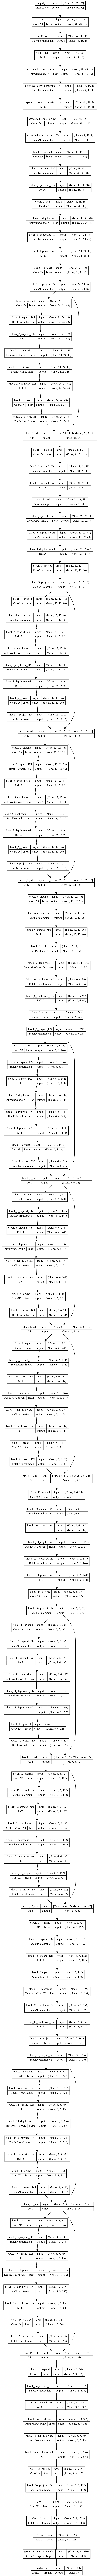

In [42]:
tf.keras.utils.plot_model(
    model,
    to_file=models_image_path,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",  # TB for vertical plot, LR for horizontal plot
    expand_nested=True,
    layer_range=None,
    dpi=200,
    show_layer_activations=True,
)

# Save the model summary


In [43]:
mltk_summary = summarize_model(model)
print(mltk_summary)


Model: "mobilenetv2_0.35_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 16)   432         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 16)   0           ['bn_Conv1[0][0]']               
                                                                                

In [44]:
from contextlib import redirect_stdout

with open(models_summary_path, "w", encoding='utf-8') as f:
    with redirect_stdout(f):
        #model.summary()
        print(mltk_summary)

In [45]:
def parse_model_summary(filepath): 
    # Parse the MLTK model summary to grab important metrics   
    with open(filepath, "r") as f:
        lines = f.readlines() # list containing lines of file
        #columns = [] # To store column names

        i = 1
        for line in lines:
            line = line.strip() # remove leading/trailing white spaces
            if line.startswith("Total params:"):
                total_params = line.split()[-1]
                total_params = int(total_params.replace(",", ""))
            elif line.startswith("Trainable params:"):
                trainable_params = line.split()[-1]
                trainable_params =  int(trainable_params.replace(",", ""))
            elif line.startswith("Non-trainable params:"):
                non_trainable_params = line.split()[-1]
                non_trainable_params = int(non_trainable_params.replace(",", ""))
            elif line.startswith("Total MACs:"):
                MACs = line.split()[-2] + " " + line.split()[-1]
                #MACs = (float(MACs))
            elif line.startswith("Total OPs:"):
                FLOPs = line.split()[-2] + " " + line.split()[-1]
                #FLOPs = (float(FLOPs))
            else:
                pass
    
    return (total_params, trainable_params, non_trainable_params, MACs, FLOPs)


In [46]:
# MLTK profile model reads the mode from a path - only works for MLTK models! / Model must be trained first

#profiling_results = profile_model(model, accelerator='None', build=False)

In [47]:
total_params, trainable_params, non_trainable_params, MACs, FLOPs = parse_model_summary(models_summary_path)        

In [48]:
print(f"MACs: {MACs} - FLOPs {FLOPs}")


MACs: 10.658 M - FLOPs 22.295 M


In [49]:
model_stats["MACs"] = MACs
model_stats["FLOPs"] = FLOPs
model_stats["total_params"] = total_params
model_stats["trainable_params"] = trainable_params
model_stats["non_trainable_params"] = non_trainable_params

# Save the model

In [50]:
model.save(models_tf_path)
models_tf_path

WindowsPath('i:/tinyml/tiny_cnn/models/mobilenetv2_0.35_96_c3_o3_keras/mobilenetv2_0.35_96_c3_o3_keras.h5')

In [51]:
model_stats["model_size_kb"] = get_file_size(models_tf_path)

File size in bytes is 2130072
File size in kilobytes is 2080.1484375


In [52]:
#reconstructed_model = keras.models.load_model(models_tf_path)

# Let's check:
# np.testing.assert_allclose(
#     model.predict(test_input), reconstructed_model.predict(test_input)
# )

# # The reconstructed model is already compiled and has retained the optimizer
# # state, so training can resume:
# reconstructed_model.fit(test_input, test_target)


# Conversion to TFLite

In [53]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter = tf.lite.TFLiteConverter.from_saved_model(models_path)
tflite_model = converter.convert()


# Save the model.
with open(models_tflite_path, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmpaa8ip3l1\assets


In [54]:
model_stats["tflite_model_size_kb"] = get_file_size(models_tflite_path)

File size in bytes is 1588020
File size in kilobytes is 1550.80078125


In [55]:
model_stats["time_stamp"] = datetime.datetime.now()

In [56]:
#csv_file_name = f"{base_model_name}_stats.csv"
csv_file_name = f"model_stats.csv"
csv_path = Path.cwd().joinpath(csv_file_name)
append_dict_to_csv(csv_path, model_stats)

# Getting peak memory info

In [57]:
models_peak_memory_path = models_dir.joinpath(model_name, f"{model_name}_peak_memory")

In [58]:
! python i:\tinyml\tflite-tools\tflite_tools.py -i $models_tflite_opt_path --csv $models_peak_memory_path
! explorer $models_peak_memory_path

Traceback (most recent call last):
  File "i:\tinyml\tflite-tools\tflite_tools.py", line 49, in <module>
    main()
  File "i:\tinyml\tflite-tools\tflite_tools.py", line 23, in main
    model = TFLiteModel.load_from_file(args.input_path)
  File "i:\tinyml\tflite-tools\tflite_tools\tflite_model.py", line 118, in load_from_file
    with open(model_path, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: 'i:\\tinyml\\tiny_cnn\\models\\mobilenetv2_0.35_96_c3_o3_keras\\mobilenetv2_0.35_96_c3_o3_keras_INT8.tflite'


In [59]:
#built_model = model.build(input_shape)

In [60]:
#help(model)

In [61]:
# Login to W&B
wandb.login()

# Initialize a W&B run
run = wandb.init(project=f'{base_model_name}') #, group='alpha variations')

config = wandb.config
config.update(model_stats)
#wandb.log({'augmented data': augment_table})

# Finish the run
wandb.finish()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: susbrock. Use `wandb login --relogin` to force relogin


## Running inference on TFLite Interpreter

In [62]:
# # Initialize the TFLite interpreter
# interpreter = tf.lite.Interpreter(model_content=tflite_model)

# # Allocate the tensors
# interpreter.allocate_tensors()

In [63]:
# # Get input/output layer information
# i_details = interpreter.get_input_details()[0]
# o_details = interpreter.get_output_details()[0]

# # Get input quantization parameters.
# i_quant = i_details["quantization_parameters"]
# try:
#     i_scale      = i_quant['scales'][0]
# except:
#     i_scale = 1

# try:
#     i_zero_point = i_quant['zero_points'][0]
# except:
#     i_zero_point = 0

In [64]:
#i_details

# Conversion to TFLite with Quantization
A representative dataset is needed for quantization

## Create representative dataset for quantization

In [65]:
# data_dir = Path.cwd().parent.joinpath("lemon_dataset", "docs", "data")
# dataset_path = Path.cwd().joinpath("datasets", "lemon_dataset")
# dataset_path.exists()

# shuffle_seed = 42


# def get_lemon_quality_dataset(
#     dataset_path, img_width, img_height, batch_size, normalize=True
# ):
#     """Fetches the lemon quality dataset and prints dataset info. It normalizes the image data to range [0,1] by default.

#     Args:
#         dataset_path (Path): the file location of the dataset. Subfolders "train", "test", and "val" are expected.
#         normalize (boolean): Normalizes the image data to range [0, 1]. Default: True

#     Returns:
#         (train_ds, val_ds, test_ds, class_names) (tuple(tf.datasets)): Tensorflow datasets for train, validation and test.

#     """
#     if dataset_path.exists():
#         try:
#             train_dir = dataset_path.joinpath("train")
#             val_dir = dataset_path.joinpath("val")
#             test_dir = dataset_path.joinpath("test")
#         except:
#             print(f"Please check the folder structure of {dataset_path}.")
#             raise

#     print("Preparing training dataset...")
#     train_ds = tf.keras.utils.image_dataset_from_directory(
#         train_dir,
#         subset=None,
#         seed=shuffle_seed,
#         image_size=(img_height, img_width),
#         # batch_size=1)
#     )

#     class_names = train_ds.class_names

#     print("Preparing validation dataset...")
#     val_ds = tf.keras.utils.image_dataset_from_directory(
#         val_dir,
#         subset=None,
#         seed=shuffle_seed,
#         image_size=(img_height, img_width),
#         # batch_size=batch_size)
#     )

#     print("Preparing test dataset...")
#     test_ds = tf.keras.utils.image_dataset_from_directory(
#         test_dir,
#         subset=None,
#         seed=shuffle_seed,
#         image_size=(img_height, img_width),
#         # batch_size=batch_size)
#     )

#     # https://github.com/tensorflow/tensorflow/issues/56089

#     # # Normalize the data to the range [0, 1]
#     # if normalize:
#     #     normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

#     #     train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#     #     val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
#     #     test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
#     # else:
#     #     pass

#     print(f"Class names: {class_names}")
#     print(train_ds.element_spec)
#     #print(f"Normalize: {normalize}")
#     return (train_ds, val_ds, test_ds, class_names)

In [66]:
# IMG_WIDTH = input_shape[1]
# IMG_HEIGHT = input_shape[0]
# BATCH_SIZE = 32

# train_ds, val_ds, test_ds, labels = get_lemon_quality_dataset(
#     dataset_path, IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE
# )

In [67]:
# rescale = tf.keras.layers.Rescaling(1.0 / 255, offset=-1)
# train_ds = train_ds.map(lambda x, y: (rescale(x), y))
# train_ds

In [68]:
# rep_ds = train_ds.unbatch()
# rep_ds

In [69]:
# def representative_data_gen():
#     # for input_value in train_ds.unbatch.batch(1).take(100):
#     for input_value, output_value in rep_ds.batch(1).take(100):
#         # Model has only one input so each data point has one element.
#         print(input_value)
#         yield [input_value]

# Linux playground

In [70]:
#! wsl ls ./models

In [71]:
# ! wsl pwd

In [72]:
# ! wsl ls ./models -l >model.txt

In [73]:
#! wsl ls ./models -laR 

In [74]:
#linux_path = models_tflite_path.as_posix()

In [75]:
#! wsl i:\tinyml\tiny_cnn\benchmarking\linux_x86-64_benchmark_model 

In [76]:
#! wsl ./benchmarking/linux_x86-64_benchmark_model --graph=$models_tflite_path --num_threads=1 --enable_op_profiling=true

## Convert model to INT8

In [77]:
# converter_INT = tf.lite.TFLiteConverter.from_keras_model(model)

# # Set the optimization flag.
# converter_INT.optimizations = [tf.lite.Optimize.DEFAULT]
# # Enforce integer only quantization
# converter_INT.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter_INT.inference_input_type = tf.int8
# converter_INT.inference_output_type = tf.int8
# # Provide a representative dataset to ensure we quantize correctly.
# # converter_INT.representative_dataset = representative_dataset(rep_ds)
# converter_INT.representative_dataset = representative_data_gen
# # converter_INT.representative_dataset = rep_ds
# model_tflite_opt = converter_INT.convert()

# # Save the model to disk
# with open(models_tflite_opt_path, "wb") as f:
#     f.write(model_tflite_opt)

In [78]:
# model_stats["tflite_INT8_model_size_kb"] = get_file_size(models_tflite_opt_path)

In [79]:
# # repr_ds = test_ds.unbatch()

# # def representative_data_gen():
# #   for i_value, o_value in repr_ds.batch(1).take(48):
# #     yield [i_value]
# converter_opt = tf.lite.TFLiteConverter.from_keras_model(model)
# #converter_opt = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
# # converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
# converter_opt.optimizations = [tf.lite.Optimize.DEFAULT]
# #converter_opt.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# #converter_opt.inference_input_type = tf.int8

# tflite_model_opt = converter_opt.convert()

# # Save the model.
# with open(models_tflite_opt_path, 'wb') as f:
#   f.write(tflite_model_opt)


In [80]:
# str(models_tflite_opt_path)


In [81]:
models_tf_path

WindowsPath('i:/tinyml/tiny_cnn/models/mobilenetv2_0.35_96_c3_o3_keras/mobilenetv2_0.35_96_c3_o3_keras.h5')